# Assignment 01

In [54]:
%matplotlib inline

In [70]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

In [99]:
class Data:

    def __init__(self, size):
        self.size = size
        self.X = np.linspace(0, 1, size)
        self.noise = np.random.normal(0, 0.1, size)
        self.ground_truth = np.sin(2 * np.pi * self.X)
        self.Y = self.ground_truth + self.noise
        self.X_test, self.X_trainer, self.Y_test, self.Y_trainer  = train_test_split(self.X, self.Y, test_size = 0.5, random_state = 10)

In [100]:
class Model:
    
    def __init__(self, degree, lambda_val: float = 0):
        self.degree = degree
        self.lambda_val = lambda_val
        self.model = None
        self.weights = np.array([])

    def trainer(self, data: Data):
        self.model = make_pipeline(PolynomialFeatures(self.degree), Ridge(alpha=self.lambda_val, solver='auto'))
        self.model.fit(data.X_trainer[:, np.newaxis], data.Y_trainer)
        self.weights = self.model.steps[-1][1].coef_.copy()
        self.weights[0] = self.model.steps[-1][1].intercept_
        return self.model

    def error(self, X, y):
        y_pred = self.predict(X)
        return np.sqrt(mean_squared_error(y, y_pred))

    def predict(self, X):
        return self.model.predict(X[:, np.newaxis])



    def plot(self, axis, data: Data):
        x_plot = np.linspace(0, 1, 100)
        y_plot = self.predict(x_plot)

        plt.plot(data.X, data.ground_truth, color='green')
        axis.scatter(data.X_trainer, data.Y_trainer, facecolors='none', edgecolors='b')
        plt.plot(x_plot, y_plot, color='red', label=f'Degree = {self.degree}')
        axis.legend(loc=2, prop={'size': 15}, frameon=True)

        return axis

Y values are generated using the formula (y = sin(2*pi*X) + N).

In [101]:
data = Data(20)

Generated and trained 10 models, 1 for each degree in-range [0,9]
<br>
Used scikit-learn to calculate model-weights. 

In [102]:
models = [Model(x) for x in range(10)]
for model in models:
    model.trainer(data)

Weights for models with the following degrees (0, 1, 6, 9)

In [103]:
orders = [0, 1, 6, 9]
weights = pd.DataFrame()

for order in orders:
    temp = pd.DataFrame({f'degree={order}': models[order].weights})
    weights = pd.concat([weights, temp], axis=1)

print(weights.round(4).fillna(''))

  degree=0 degree=1 degree=6     degree=9
0   0.2316   1.2375    3.476      -1.2989
1           -2.2223 -59.7496     111.1945
2                    442.526   -2002.4091
3                   -1459.36   16905.2878
4                    2363.87  -78146.7841
5                   -1878.38  214109.2252
6                    588.993 -357839.8191
7                             358234.2246
8                            -197285.5135
9                              45928.0123


Plotting models of the following degrees (0, 1, 6, 9)

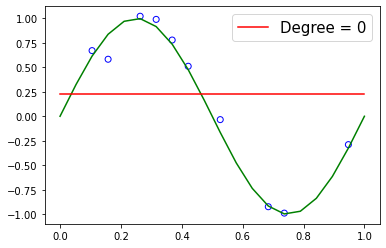

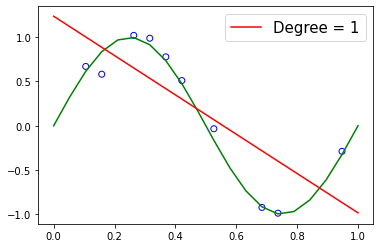

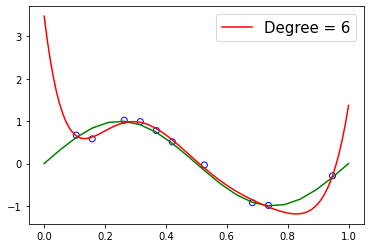

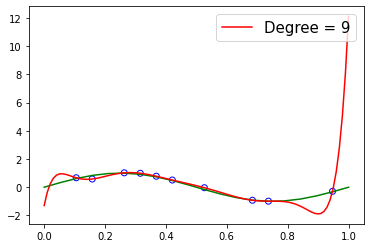

In [104]:
for i, order in enumerate(orders):
    figure, axis = plt.subplots()
    models[order].plot(axis, data)
    axis.legend(loc=1, prop={'size': 15}, frameon=True)
    plt.show()

The model-plot for [degree = 9] is an overfit.

Plotting the RMS error for each model

degrees: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


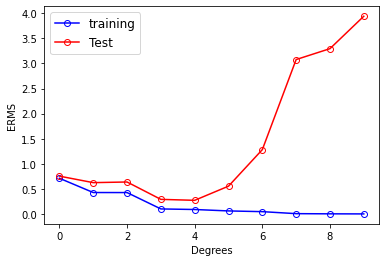

In [105]:
training_errors = []
test_errors = []
degs = list(range(len(models)))
print("degrees:", degs)

for model in models:
    training_errors.append(model.error(data.X_trainer, data.Y_trainer))
    test_errors.append(model.error(data.X_test, data.Y_test))

figure = plt.figure()
axis = figure.add_subplot()

plt.plot(degs, training_errors, color='blue', marker='o', markerfacecolor='none', label='training')
plt.plot(degs, test_errors, color='red', marker='o', markerfacecolor='none', label='Test')

axis.set_ylabel('ERMS')
axis.set_xlabel('Degrees')

axis.legend(loc=2, prop={'size': 12}, frameon=True)
plt.show()

Generating 100 new data points and fitting model(degree=9).

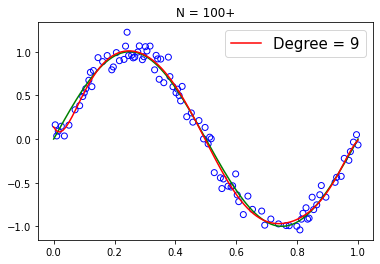

In [106]:
large_data = Data(200)
d9_model = Model(9)
d9_model.trainer(large_data)

figure, axis = plt.subplots()
d9_model.plot(axis, large_data)
plt.title('N = 100+')
axis.legend(loc=1, prop={'size': 15}, frameon=True)
plt.show()

The new model doesn't overfit due to the increased amount of data.

Trainnig 6 new models using regularization with λ = (1, 1/10, 1/100, 1/1000, 1/10000, 1/100000)

In [107]:
hy_pams = list(10 ** -x for x in range(6))
models = [Model(9, hp) for hp in hy_pams]
for model in models:
    model.trainer(data)

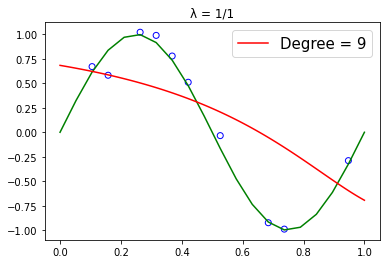

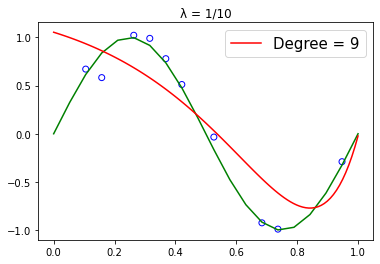

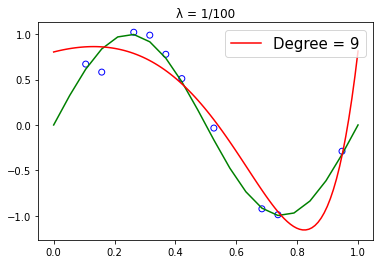

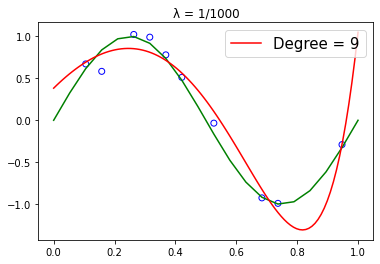

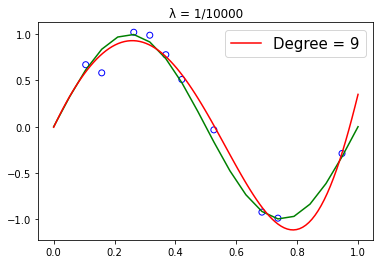

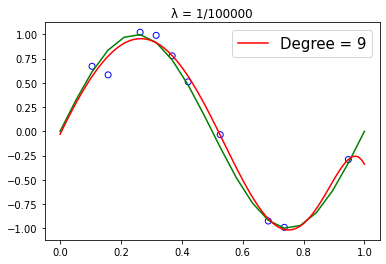

In [108]:
for i, hp in enumerate(hy_pams):
    figure, axis = plt.subplots()
    models[i].plot(axis, data)
    plt.title(f'λ = 1/{1/hp:.0f}')
    axis.legend(loc=1, prop={'size': 15}, frameon=True)
    plt.show()

Training  new models using hyper parameters ln(λ) = [-30, -5]

In [109]:
hy_pams = np.arange(-30,-5)
models = [Model(9, np.exp(hp)) for hp in hy_pams]
for model in models:
    model.trainer(data)

Plotting training and test error for new models.

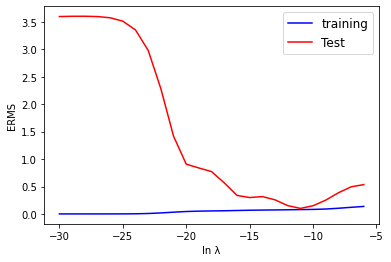

In [110]:
training_err = []
test_errors = []

for model in models:
    training_err.append(model.error(data.X_trainer, data.Y_trainer))
    test_errors.append(model.error(data.X_test, data.Y_test))
    
figure = plt.figure()
axis = figure.add_subplot()

plt.plot(hy_pams, training_err, color='blue', label='training')
plt.plot(hy_pams, test_errors, color='red', label='Test')

axis.set_ylabel('ERMS')
axis.set_xlabel('In λ')

axis.legend(loc=1, prop={'size': 12}, frameon=True)
plt.show()

the model with lowest test error.

In [111]:
minimum = np.argmin(test_errors)
best_perf = models[minimum]
with np.printoptions(precision=4, suppress=True):
    print(f'Based on the test performance, the best model with deg 9 is ln λ = {np.log(best_perf.lambda_val)}')
    print(f'Weights: {best_perf.weights}')

Based on the test performance, the best model with deg 9 is ln λ = -11.0
Weights: [ -0.071    7.1657  -9.3503 -12.7468   0.8489  10.0954  10.6111   5.374
  -2.192   -9.9115]


Plotting the best model found above.

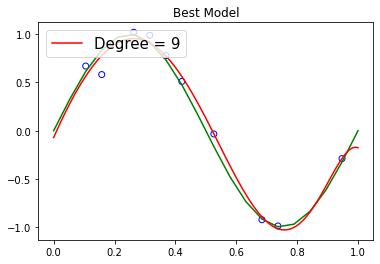

In [112]:
figure, axis = plt.subplots()
best_perf.plot(axis, data)
plt.title('Best Model')
plt.show()